Animation saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

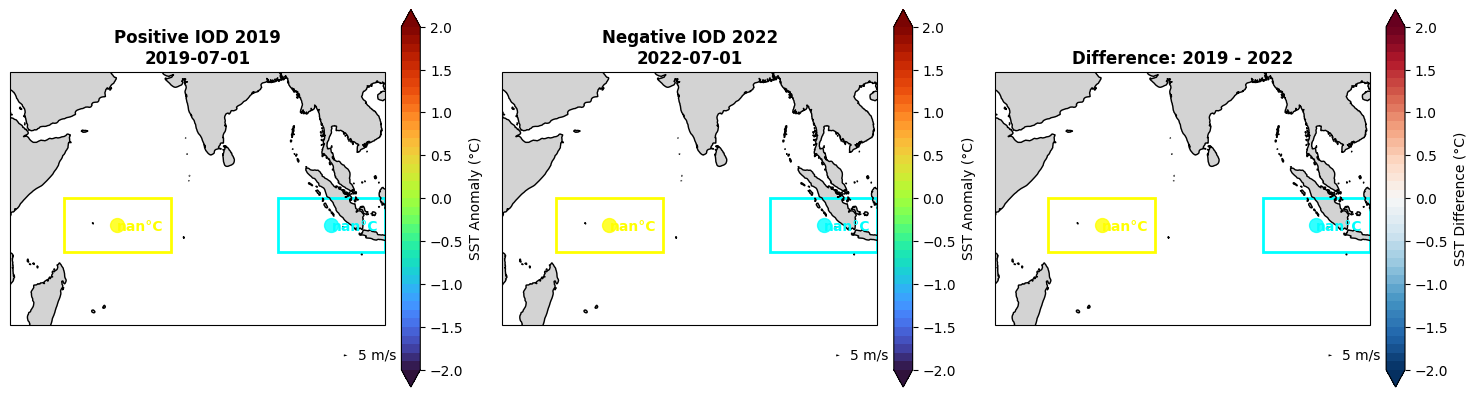

In [10]:
# ==========================================================
# IOD OCEAN RESPONSE ANIMATION (POLES HIGHLIGHTED)
# Positive IOD 2019 vs Negative IOD 2022
# ==========================================================

!pip -q install xarray netCDF4 cartopy matplotlib ffmpeg-python cmocean

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
import requests, os, warnings
warnings.filterwarnings("ignore")
import cmocean

# ----------------- DOWNLOAD FUNCTION ---------------------
def download(url, fname):
    if not os.path.exists(fname):
        print(f"Downloading {fname}...")
        r = requests.get(url)
        open(fname, 'wb').write(r.content)

# SST anomaly data
download("https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/sst.day.anom.2019.nc", "sst2019.nc")
download("https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/sst.day.anom.2022.nc", "sst2022.nc")

# Wind data
download("https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/uwnd.sig995.2019.nc", "uwnd2019.nc")
download("https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/vwnd.sig995.2019.nc", "vwnd2019.nc")
download("https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/uwnd.sig995.2022.nc", "uwnd2022.nc")
download("https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/vwnd.sig995.2022.nc", "vwnd2022.nc")

# ----------------- LOAD DATA -----------------------------
sst_pos = xr.open_dataset("sst2019.nc")['anom']
sst_neg = xr.open_dataset("sst2022.nc")['anom']

u_pos = xr.open_dataset("uwnd2019.nc")['uwnd']
v_pos = xr.open_dataset("vwnd2019.nc")['vwnd']

u_neg = xr.open_dataset("uwnd2022.nc")['uwnd']
v_neg = xr.open_dataset("vwnd2022.nc")['vwnd']

# ----------------- SUBSET INDIAN OCEAN -------------------
sst_pos = sst_pos.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2019-07","2019-10"))
u_pos = u_pos.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2019-07","2019-10"))
v_pos = v_pos.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2019-07","2019-10"))

sst_neg = sst_neg.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2022-07","2022-10"))
u_neg = u_neg.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2022-07","2022-10"))
v_neg = v_neg.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2022-07","2022-10"))

# ----------------- REMOVE SEASONAL MEAN ------------------
sst_pos -= sst_pos.mean('time')
sst_neg -= sst_neg.mean('time')
u_pos -= u_pos.mean('time')
v_pos -= v_pos.mean('time')
u_neg -= u_neg.mean('time')
v_neg -= v_neg.mean('time')

# ----------------- SMOOTH DATA --------------------------
sst_pos = sst_pos.rolling(time=3, center=True).mean()
sst_neg = sst_neg.rolling(time=3, center=True).mean()
u_pos = u_pos.rolling(time=3, center=True).mean()
v_pos = v_pos.rolling(time=3, center=True).mean()
u_neg = u_neg.rolling(time=3, center=True).mean()
v_neg = v_neg.rolling(time=3, center=True).mean()

# ----------------- QUVER SKIP ---------------------------
skip = (slice(None,None,10), slice(None,None,10))

# ----------------- ANIMATION ---------------------------
fig = plt.figure(figsize=(18,6))

# Define pole boxes
w_pole = dict(lon=slice(50,70), lat=slice(-10,0))   # western pole
e_pole = dict(lon=slice(90,110), lat=slice(-10,0))  # eastern pole

def animate(i):
    plt.clf()

    # ---------------- Positive IOD ----------------
    ax1 = plt.subplot(1,3,1, projection=ccrs.PlateCarree())
    ax1.set_extent([40,110,-20,20])
    ax1.coastlines(); ax1.add_feature(cfeature.LAND, color='lightgray')

    sst = sst_pos.isel(time=i)
    u = u_pos.isel(time=i)
    v = v_pos.isel(time=i)

    cf = ax1.contourf(sst.lon, sst.lat, sst, levels=np.linspace(-2,2,41),
                      cmap='turbo', extend='both')

    speed = np.sqrt(u**2 + v**2)
    q = ax1.quiver(u.lon[skip[1]], u.lat[skip[0]], u.values[skip], v.values[skip],
                   speed.values[skip], scale=500, cmap='viridis', width=0.003)
    ax1.quiverkey(q, X=0.9, Y=-0.12, U=5, label='5 m/s', labelpos='E')

    # Pole boxes
    ax1.add_patch(plt.Rectangle((50,-10),20,10, edgecolor='yellow', facecolor='none', lw=2))
    ax1.add_patch(plt.Rectangle((90,-10),20,10, edgecolor='cyan', facecolor='none', lw=2))

    # Highlight pole SSTs with dots
    w_sst = sst.sel(lon=w_pole['lon'], lat=w_pole['lat']).mean().values
    e_sst = sst.sel(lon=e_pole['lon'], lat=e_pole['lat']).mean().values
    ax1.scatter(60, -5, color='yellow', s=100, alpha=0.8)
    ax1.text(60, -6, f"{w_sst:.2f}°C", color='yellow', fontsize=10, fontweight='bold')
    ax1.scatter(100, -5, color='cyan', s=100, alpha=0.8)
    ax1.text(100, -6, f"{e_sst:.2f}°C", color='cyan', fontsize=10, fontweight='bold')

    ax1.set_title(f"Positive IOD 2019\n{str(sst.time.values)[:10]}", fontsize=12, fontweight='bold')

    # ---------------- Negative IOD ----------------
    ax2 = plt.subplot(1,3,2, projection=ccrs.PlateCarree())
    ax2.set_extent([40,110,-20,20])
    ax2.coastlines(); ax2.add_feature(cfeature.LAND, color='lightgray')

    sst = sst_neg.isel(time=i)
    u = u_neg.isel(time=i)
    v = v_neg.isel(time=i)

    cf2 = ax2.contourf(sst.lon, sst.lat, sst, levels=np.linspace(-2,2,41),
                       cmap='turbo', extend='both')

    speed = np.sqrt(u**2 + v**2)
    q2 = ax2.quiver(u.lon[skip[1]], u.lat[skip[0]], u.values[skip], v.values[skip],
                    speed.values[skip], scale=500, cmap='viridis', width=0.003)
    ax2.quiverkey(q2, X=0.9, Y=-0.12, U=5, label='5 m/s', labelpos='E')

    # Pole boxes
    ax2.add_patch(plt.Rectangle((50,-10),20,10, edgecolor='yellow', facecolor='none', lw=2))
    ax2.add_patch(plt.Rectangle((90,-10),20,10, edgecolor='cyan', facecolor='none', lw=2))

    # Highlight pole SSTs
    w_sst = sst.sel(lon=w_pole['lon'], lat=w_pole['lat']).mean().values
    e_sst = sst.sel(lon=e_pole['lon'], lat=e_pole['lat']).mean().values
    ax2.scatter(60, -5, color='yellow', s=100, alpha=0.8)
    ax2.text(60, -6, f"{w_sst:.2f}°C", color='yellow', fontsize=10, fontweight='bold')
    ax2.scatter(100, -5, color='cyan', s=100, alpha=0.8)
    ax2.text(100, -6, f"{e_sst:.2f}°C", color='cyan', fontsize=10, fontweight='bold')

    ax2.set_title(f"Negative IOD 2022\n{str(sst.time.values)[:10]}", fontsize=12, fontweight='bold')

    # ---------------- Difference Panel ----------------
    ax3 = plt.subplot(1,3,3, projection=ccrs.PlateCarree())
    ax3.set_extent([40,110,-20,20])
    ax3.coastlines(); ax3.add_feature(cfeature.LAND, color='lightgray')

    sst_diff = sst_pos.isel(time=i) - sst_neg.isel(time=i)
    cf3 = ax3.contourf(sst_diff.lon, sst_diff.lat, sst_diff, levels=np.linspace(-2,2,41),
                       cmap='RdBu_r', extend='both')

    u_diff = u_pos.isel(time=i) - u_neg.isel(time=i)
    v_diff = v_pos.isel(time=i) - v_neg.isel(time=i)
    speed_diff = np.sqrt(u_diff**2 + v_diff**2)
    q3 = ax3.quiver(u_diff.lon[skip[1]], u_diff.lat[skip[0]], u_diff.values[skip], v_diff.values[skip],
                    speed_diff.values[skip], scale=500, cmap='viridis', width=0.003)
    ax3.quiverkey(q3, X=0.9, Y=-0.12, U=5, label='5 m/s', labelpos='E')

    # Pole boxes + dots
    ax3.add_patch(plt.Rectangle((50,-10),20,10, edgecolor='yellow', facecolor='none', lw=2))
    ax3.add_patch(plt.Rectangle((90,-10),20,10, edgecolor='cyan', facecolor='none', lw=2))
    w_sst = sst_diff.sel(lon=w_pole['lon'], lat=w_pole['lat']).mean().values
    e_sst = sst_diff.sel(lon=e_pole['lon'], lat=e_pole['lat']).mean().values
    ax3.scatter(60, -5, color='yellow', s=100, alpha=0.8)
    ax3.text(60, -6, f"{w_sst:.2f}°C", color='yellow', fontsize=10, fontweight='bold')
    ax3.scatter(100, -5, color='cyan', s=100, alpha=0.8)
    ax3.text(100, -6, f"{e_sst:.2f}°C", color='cyan', fontsize=10, fontweight='bold')

    ax3.set_title("Difference: 2019 - 2022", fontsize=12, fontweight='bold')

    # Colorbars
    if i==0:
        cbar1 = fig.colorbar(cf, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
        cbar1.set_label('SST Anomaly (°C)')
        cbar2 = fig.colorbar(cf2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
        cbar2.set_label('SST Anomaly (°C)')
        cbar3 = fig.colorbar(cf3, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04)
        cbar3.set_label('SST Difference (°C)')

# ----------------- CREATE ANIMATION ----------------------
frames = min(len(sst_pos.time), len(sst_neg.time))
ani = FuncAnimation(fig, animate, frames=frames, interval=500)

# ----------------- SAVE VIDEO ---------------------------
video_file = "IOD_3Panel_Poles_Highlighted.mp4"
ani.save(video_file, writer='ffmpeg', fps=5)
print("Animation saved!")

# For Colab download
from google.colab import files
files.download(video_file)


Animation saved!


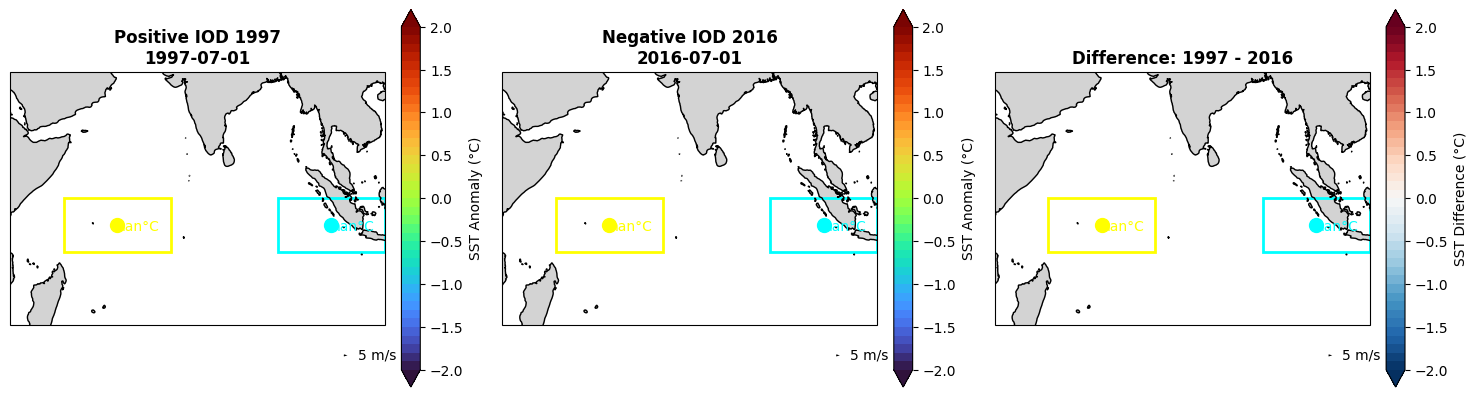

In [11]:
# ==========================================================
# IOD OCEAN RESPONSE ANIMATION (STRONG CASE)
# Positive IOD 1997 vs Negative IOD 2016
# ==========================================================

!pip -q install xarray netCDF4 cartopy matplotlib ffmpeg-python cmocean

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
import requests, os, warnings
warnings.filterwarnings("ignore")
import cmocean

# ----------------- DOWNLOAD FUNCTION ---------------------
def download(url, fname):
    if not os.path.exists(fname):
        print(f"Downloading {fname}...")
        r = requests.get(url)
        open(fname, 'wb').write(r.content)

# SST anomaly data
download("https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/sst.day.anom.1997.nc", "sst1997.nc")
download("https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2.highres/sst.day.anom.2016.nc", "sst2016.nc")

# Wind data
download("https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/uwnd.sig995.1997.nc", "uwnd1997.nc")
download("https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/vwnd.sig995.1997.nc", "vwnd1997.nc")
download("https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/uwnd.sig995.2016.nc", "uwnd2016.nc")
download("https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/surface/vwnd.sig995.2016.nc", "vwnd2016.nc")

# ----------------- LOAD DATA -----------------------------
sst_pos = xr.open_dataset("sst1997.nc")['anom']
sst_neg = xr.open_dataset("sst2016.nc")['anom']

u_pos = xr.open_dataset("uwnd1997.nc")['uwnd']
v_pos = xr.open_dataset("vwnd1997.nc")['vwnd']

u_neg = xr.open_dataset("uwnd2016.nc")['uwnd']
v_neg = xr.open_dataset("vwnd2016.nc")['vwnd']

# ----------------- SUBSET INDIAN OCEAN -------------------
sst_pos = sst_pos.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("1997-07","1997-10"))
u_pos = u_pos.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("1997-07","1997-10"))
v_pos = v_pos.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("1997-07","1997-10"))

sst_neg = sst_neg.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2016-07","2016-10"))
u_neg = u_neg.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2016-07","2016-10"))
v_neg = v_neg.sel(lon=slice(40,110), lat=slice(-20,20), time=slice("2016-07","2016-10"))

# ----------------- REMOVE SEASONAL MEAN ------------------
sst_pos -= sst_pos.mean('time')
sst_neg -= sst_neg.mean('time')
u_pos -= u_pos.mean('time')
v_pos -= v_pos.mean('time')
u_neg -= u_neg.mean('time')
v_neg -= v_neg.mean('time')

# ----------------- SMOOTH DATA --------------------------
sst_pos = sst_pos.rolling(time=3, center=True).mean()
sst_neg = sst_neg.rolling(time=3, center=True).mean()
u_pos = u_pos.rolling(time=3, center=True).mean()
v_pos = v_pos.rolling(time=3, center=True).mean()
u_neg = u_neg.rolling(time=3, center=True).mean()
v_neg = v_neg.rolling(time=3, center=True).mean()

# ----------------- QUVER SKIP ---------------------------
skip = (slice(None,None,10), slice(None,None,10))

# ----------------- ANIMATION ---------------------------
fig = plt.figure(figsize=(18,6))

# Define pole boxes
w_pole = dict(lon=slice(50,70), lat=slice(-10,0))   # western pole
e_pole = dict(lon=slice(90,110), lat=slice(-10,0))  # eastern pole

def animate(i):
    plt.clf()

    # ---------------- Positive IOD ----------------
    ax1 = plt.subplot(1,3,1, projection=ccrs.PlateCarree())
    ax1.set_extent([40,110,-20,20])
    ax1.coastlines(); ax1.add_feature(cfeature.LAND, color='lightgray')

    sst = sst_pos.isel(time=i)
    u = u_pos.isel(time=i)
    v = v_pos.isel(time=i)

    cf = ax1.contourf(sst.lon, sst.lat, sst, levels=np.linspace(-2,2,41),
                      cmap='turbo', extend='both')

    speed = np.sqrt(u**2 + v**2)
    q = ax1.quiver(u.lon[skip[1]], u.lat[skip[0]], u.values[skip], v.values[skip],
                   speed.values[skip], scale=500, cmap='viridis', width=0.003)
    ax1.quiverkey(q, X=0.9, Y=-0.12, U=5, label='5 m/s', labelpos='E')

    # Pole boxes + values
    ax1.add_patch(plt.Rectangle((50,-10),20,10, edgecolor='yellow', facecolor='none', lw=2))
    ax1.add_patch(plt.Rectangle((90,-10),20,10, edgecolor='cyan', facecolor='none', lw=2))
    w_sst = sst.sel(lon=w_pole['lon'], lat=w_pole['lat']).mean().values
    e_sst = sst.sel(lon=e_pole['lon'], lat=e_pole['lat']).mean().values
    ax1.scatter(60, -5, color='yellow', s=100)
    ax1.text(60, -6, f"{w_sst:.2f}°C", color='yellow')
    ax1.scatter(100, -5, color='cyan', s=100)
    ax1.text(100, -6, f"{e_sst:.2f}°C", color='cyan')

    ax1.set_title(f"Positive IOD 1997\n{str(sst.time.values)[:10]}", fontsize=12, fontweight='bold')

    # ---------------- Negative IOD ----------------
    ax2 = plt.subplot(1,3,2, projection=ccrs.PlateCarree())
    ax2.set_extent([40,110,-20,20])
    ax2.coastlines(); ax2.add_feature(cfeature.LAND, color='lightgray')

    sst = sst_neg.isel(time=i)
    u = u_neg.isel(time=i)
    v = v_neg.isel(time=i)

    cf2 = ax2.contourf(sst.lon, sst.lat, sst, levels=np.linspace(-2,2,41),
                       cmap='turbo', extend='both')

    speed = np.sqrt(u**2 + v**2)
    q2 = ax2.quiver(u.lon[skip[1]], u.lat[skip[0]], u.values[skip], v.values[skip],
                    speed.values[skip], scale=500, cmap='viridis', width=0.003)
    ax2.quiverkey(q2, X=0.9, Y=-0.12, U=5, label='5 m/s', labelpos='E')

    ax2.add_patch(plt.Rectangle((50,-10),20,10, edgecolor='yellow', facecolor='none', lw=2))
    ax2.add_patch(plt.Rectangle((90,-10),20,10, edgecolor='cyan', facecolor='none', lw=2))
    w_sst = sst.sel(lon=w_pole['lon'], lat=w_pole['lat']).mean().values
    e_sst = sst.sel(lon=e_pole['lon'], lat=e_pole['lat']).mean().values
    ax2.scatter(60, -5, color='yellow', s=100)
    ax2.text(60, -6, f"{w_sst:.2f}°C", color='yellow')
    ax2.scatter(100, -5, color='cyan', s=100)
    ax2.text(100, -6, f"{e_sst:.2f}°C", color='cyan')

    ax2.set_title(f"Negative IOD 2016\n{str(sst.time.values)[:10]}", fontsize=12, fontweight='bold')

    # ---------------- Difference Panel ----------------
    ax3 = plt.subplot(1,3,3, projection=ccrs.PlateCarree())
    ax3.set_extent([40,110,-20,20])
    ax3.coastlines(); ax3.add_feature(cfeature.LAND, color='lightgray')

    sst_diff = sst_pos.isel(time=i) - sst_neg.isel(time=i)
    cf3 = ax3.contourf(sst_diff.lon, sst_diff.lat, sst_diff, levels=np.linspace(-2,2,41),
                       cmap='RdBu_r', extend='both')

    u_diff = u_pos.isel(time=i) - u_neg.isel(time=i)
    v_diff = v_pos.isel(time=i) - v_neg.isel(time=i)
    speed_diff = np.sqrt(u_diff**2 + v_diff**2)
    q3 = ax3.quiver(u_diff.lon[skip[1]], u_diff.lat[skip[0]], u_diff.values[skip], v_diff.values[skip],
                    speed_diff.values[skip], scale=500, cmap='viridis', width=0.003)
    ax3.quiverkey(q3, X=0.9, Y=-0.12, U=5, label='5 m/s', labelpos='E')

    ax3.add_patch(plt.Rectangle((50,-10),20,10, edgecolor='yellow', facecolor='none', lw=2))
    ax3.add_patch(plt.Rectangle((90,-10),20,10, edgecolor='cyan', facecolor='none', lw=2))
    w_sst = sst_diff.sel(lon=w_pole['lon'], lat=w_pole['lat']).mean().values
    e_sst = sst_diff.sel(lon=e_pole['lon'], lat=e_pole['lat']).mean().values
    ax3.scatter(60, -5, color='yellow', s=100)
    ax3.text(60, -6, f"{w_sst:.2f}°C", color='yellow')
    ax3.scatter(100, -5, color='cyan', s=100)
    ax3.text(100, -6, f"{e_sst:.2f}°C", color='cyan')

    ax3.set_title("Difference: 1997 - 2016", fontsize=12, fontweight='bold')

    if i==0:
        fig.colorbar(cf, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04).set_label('SST Anomaly (°C)')
        fig.colorbar(cf2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04).set_label('SST Anomaly (°C)')
        fig.colorbar(cf3, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04).set_label('SST Difference (°C)')

frames = min(len(sst_pos.time), len(sst_neg.time))
ani = FuncAnimation(fig, animate, frames=frames, interval=500)

video_file = "IOD_1997_2016_3Panel.mp4"
ani.save(video_file, writer='ffmpeg', fps=5)
print("Animation saved!")
